<h1 style="text-align: center;">Argon Simulation Implementation with Numpy and Scipy</h1>
<br>
<br>
<p style="text-align: center;">Truman Xu</p>
<p style="text-align: center;">Jan 26, 2023</p>

## Verlet's Experiments Ran on a Supercomputer

It ran on the supercomputer at the time (CDC 6600 at NYU in 1967). It took an hour for 1200 steps for a system of 864 Argons

<h3 style="text-align: center;">CDC 6600 (Control Data Corporation)</h3>
<img src="https://upload.wikimedia.org/wikipedia/commons/c/c4/CDC_6600.jc.jpg" alt="CDC 6600" width="400"/>


## Imports

In [19]:
from itertools import combinations, permutations
import numpy as np
from numpy import linalg as LA
from scipy import ndimage as NI  
from matplotlib import pyplot as plt
import seaborn as sns

## Constants

In [5]:
n = 6.0221415e23 # /mol
m_argon = 39.948/n # gram
m_argon_kg = m_argon*1e-3 # mass of one Argon atom in kg
kb = 1.3806503e-23 # J/K
# characteristic length for lennard jones
sigma = 3.405e-10 # m
# 2.5 sigma is set as lennard jones potential cutoff
lennard_jones_cutoff = 2.5*sigma

## System Setup
Verlet reported that he had 864 Argon atoms in the system and using face-centered cubic unit cells.<br>
Face-Centered Cubic has 4 atoms per cell
$$1 \times N_{corner} + 3\times N_{face} = 4N$$
Based on this, we can calculate how many unit cells in total and for each dimension
$$
864 = 4N^3 \\
N^3 = 216 \Rightarrow N = 6
$$
With 6 unit cells per dimension, and we can find out the number of corner atoms and face atoms
$$N_{corner} = 6^3 = 216 \\
N_{face} = 3\times 6^3 = 648$$

In [157]:
rho = 1.374 # g/cm^3 @ 130K
L_cm = (m_argon*864/rho)**(1/3) # centimeter
L = L_cm *1e-2 # system dimension in m
N_cell = 6 # Unit cell per dimension
cell_len = L/N_cell
cell_len

5.780150077107651e-10

In [158]:
x_corner = np.linspace(0, L-cell_len, N_cell) # corner atom spacings
x_face = np.linspace(cell_len/2,L-cell_len/2, N_cell) # face atom spacings

grid_c = np.meshgrid(x_corner, x_corner, x_corner, indexing='ij')
grid_f = np.meshgrid(x_face, x_corner, x_face, indexing='ij')

In [159]:
# get 3 faces by rotating 90 degrees using permutations on the x_corner and x_face.
# select the first 3 items from the permutation, since they coincide with
# the three faces (this is hard code for now)
grid_3f = np.array(tuple(permutations(grid_f))[:3])

In [367]:
# Fortran style x, y, z column arrays
face_coords = np.concatenate(grid_3f.reshape(3,3,-1), axis = 1)
corner_coords = np.array(grid_c).reshape(3,-1)
# piece-wise coords array
coords = np.concatenate([face_coords, corner_coords], axis = 1).T
# coords = np.array(coords, dtype=np.float128)
print(corner_coords.shape)
print(face_coords.shape)
print(coords.shape)


(3, 216)
(3, 648)
(864, 3)


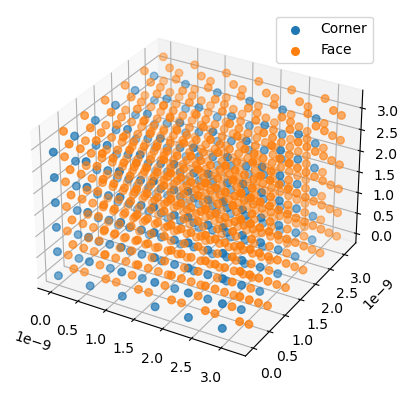

In [67]:
%matplotlib inline
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(*corner_coords, s=30, label='Corner')
ax.scatter(*face_coords, s=30, label='Face')

ax.legend()
plt.show()

## Verlet Algorithm

$$
r(t+\Delta t) = 2r(t)-r(t-\Delta t)+a(t)\Delta t^2 + O(\Delta t^4)
$$

But the first two steps need to be prepared before using Verlet algorithm:
$r(t_0)$ and $r(t_1)$

$$
r(t_0+\Delta t) = r(t) + v(t)\Delta t + a(t)\Delta t^2/2
$$

* $r(t_0)$ is intialized with FCC unit cells
* To find $r(t_0+\Delta t)$, we will need initial velocities $v(t_0)$

Temperature here is a variable <br>
$$T = 120 \; K$$
Other constants
$$
k_B = 1.3806503 \times 10^{-23} \; J/K\\
n = 6.0221415 \times 10^{23} \; mol^{-1}\\
m_{Ar} = 39.948 \; g/mol
$$
Standard deviation of velocity is given by
$$
\sigma = \sqrt{\frac{k_B T}{m_{Ar}}}
$$
We can plugin the numbers for $\sigma$ and do a dimension anaylsis
$$
\frac{k_B T}{m_{Ar}} = 
\frac{1.3806503 \times 10^{-23}J/K \times 120K }{39.948 g/mol \times 10^{-3} kg/g \times \frac{1}{6.0221415 \times 10^{23} mol^{-1}}}\\
= \frac{1.3806503 \times 120 }{39.948 \times 10^{-3} \times 6.0221415^{-1}} \cdot \frac{J}{kg}
$$
The final unit yields velocity squared; therefore, $\sigma$ has the unit of velocity
$$
\frac{J}{kg} = \frac{m^2 \cdot kg \cdot s^{-2}}{kg} = m^2 s^{-2} = \left(\frac{m}{s}\right)^2
$$

In [368]:
temp = 120 # Kelvin
kb = 1.3806503e-23
kbT_over_m = 1.3806503*temp/(39.948e-3*6.0221415**(-1)) # m^2/s^2
std_velo = (kbT_over_m)**0.5 # m/s
delta_t = 1e-14 # sec

std_velo

158.03760012674934

Average speed of the atoms is given by
$$
C_{avg} = \sqrt{\frac{8k_BT}{\pi m}}
$$

In [369]:
c_avg = (8*kbT_over_m/np.pi)**0.5
c_avg

252.19152233494052

We are gonna randomly draw initial velocities from the Gaussian distribution with the $\sigma$ we just calculated for $T=120K$, and we will check if the velocities largely conform to Maxwell-Boltzmann distribution

In [436]:
# initialize velocities
velo = np.random.normal(0, std_velo, coords.shape)
# calculate speeds (vector norm)
speeds = LA.norm(velo, axis = 1)
# find avg speed
speeds.mean()
# velo.shape
sigma_e = ((np.power(velo, 2)).sum()/(3*864))**0.5
(velo**2).sum()/(3*864)*m_argon_kg/kb

119.89539136924998

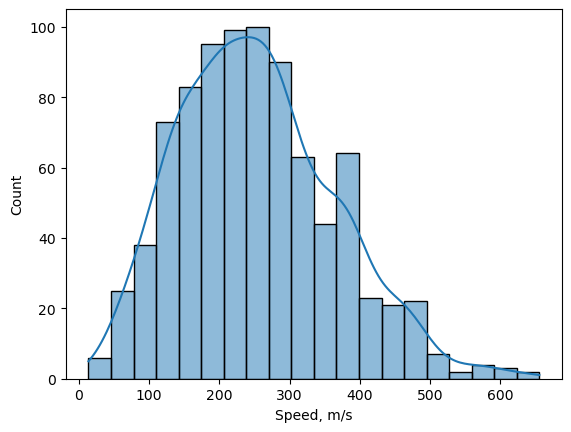

In [255]:
fig, ax = plt.subplots()
sns.histplot(speeds, bins=20, kde=True, ax=ax)
plt.xlabel('Speed, m/s')
plt.show()

## Function Implementations

The key is **avoiding** python for-loops

In [256]:
def verlet(curr_x, last_x, accl, dt) -> np.ndarray:
    """Verlet algorithm"""
    return 2*curr_x-last_x+accl*dt**2

def lennard_jones(r) -> np.ndarray:
    ''' 
    Lennard-Jones potentials
    v_LJ(r) = 4*epsilon[(sigma/r)^12-(sigma/r)^6]
    units in J
    epsilon/k_b = 120K => epsilon: J (m^2 kg s^-2)
    '''
    return 4*119.8*kb*((3.405e-10 /r)**12-(3.405e-10/r)**6)

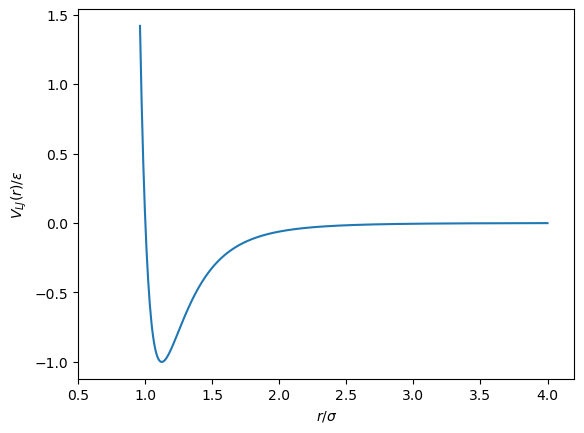

In [257]:
# Plot Lennard Jones Potential (unitless)
x_lj = np.linspace(0.96, 4, 500)
y_lj = 4*((1/x_lj)**12-(1/x_lj)**6)

plt.plot(x_lj, y_lj)
plt.xlim(0.5,4.2)
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$V_{LJ}(r)/\epsilon$')
plt.show()

## Periodic Boundary Conditions

In [258]:
def _apply_pbc_dist(dist_vecs, box_len) -> None:
    """Apply periodic boundary conditions on distance vectors. Shortest 
    distance vector will be determined from self.box_length and assigned 
    to the distance array directly"""
    mask = np.absolute(dist_vecs) > box_len/2
    dist_vecs[mask] = dist_vecs[mask]-np.sign(dist_vecs[mask])*box_len
    return dist_vecs

def _apply_pbc_dist1(dist_vecs, box_len) -> None:
    mask_pos = dist_vecs > box_len/2
    mask_neg = -dist_vecs > box_len/2
    wrapped_dist_vecs1 = dist_vecs[mask_pos] - box_len
    wrapped_dist_vecs2 = box_len + dist_vecs[mask_neg]
    dist_vecs[mask_pos] = wrapped_dist_vecs1
    dist_vecs[mask_neg] = wrapped_dist_vecs2
    return dist_vecs

(_apply_pbc_dist(dist_vecs, L) - _apply_pbc_dist1(dist_vecs, L)).sum()

0.0

In [259]:
def _apply_pbc_coord(coords, box_len) -> None:
    """Apply periodic boundary conditions on coordinates. Any out of bound 
    coord will be wrapped and place to the other side of the box. The new 
    coords will be assigned to the self.coords array directly"""
    mask1 = coords > box_len
    mask2 = coords < 0
    wrapped_coords1 = coords[mask1] % box_len
    wrapped_coords2 = box_len - ((-coords[mask2]) % box_len)
    coords[mask1] = wrapped_coords1
    coords[mask2] = wrapped_coords2

In [260]:
coords < cell_len/2

array([[False,  True, False],
       [False,  True, False],
       [False,  True, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [434]:
# combination of indices (i, j) for atom i and atom j
id_pairs = np.array(list(combinations(range(len(coords)),2)))

In [435]:
id_pairs

array([[  0,   1],
       [  0,   2],
       [  0,   3],
       ...,
       [861, 862],
       [861, 863],
       [862, 863]])

In [373]:
# dist vector from atom j to atom i
dist_vecs = coords[id_pairs[:,0]] - coords[id_pairs[:,1]]
# apply periodic boundary conditions on distances
_apply_pbc_dist(dist_vecs, L)

dist_vecs.shape

(372816, 3)

In [374]:
def _find_cutoff_ids(r_ij) -> np.ndarray:
    cutoff_mask = r_ij <= lennard_jones_cutoff
    return np.nonzero(cutoff_mask)[0]

In [375]:
lennard_jones_cutoff = 2.5*sigma
lennard_jones_cutoff

8.5125e-10

In [376]:
# update the pairwise euclidean distances from atom j to atom i
r_ij = LA.norm(dist_vecs, axis = 1)
# update the indices of r_ij that need are within the 2.5 sigma cutoff
cutoff_ids = _find_cutoff_ids(r_ij)
## 

In [377]:
def _compute_pair_potentials(r_ij, cutoff_ids) -> np.ndarray:
    """Compute the potentials from the cutoff list only. Return pairwise
    potentials of atoms"""
    pair_potentials = lennard_jones(
        r_ij[cutoff_ids]
    )
    return pair_potentials

In [415]:
def del_potential(r, dist_vecs):
    return 48*119.8*kb*dist_vecs*r**(-2)*((3.405e-10/r)**12-0.5*(3.405e-10/r)**6)

In [379]:
forces = del_potential(r_ij.reshape(-1,1)[cutoff_ids], dist_vecs[cutoff_ids])

In [380]:
forces

array([[-0.00000000e+00, -0.00000000e+00,  2.63012023e-12],
       [-0.00000000e+00, -0.00000000e+00, -2.63012023e-12],
       [-0.00000000e+00,  2.63012023e-12, -0.00000000e+00],
       ...,
       [-0.00000000e+00, -0.00000000e+00,  2.63012023e-12],
       [-0.00000000e+00, -0.00000000e+00,  2.63012023e-12],
       [-0.00000000e+00, -0.00000000e+00,  2.63012023e-12]])

In [381]:
_pair_potentials = _compute_pair_potentials(r_ij, cutoff_ids)

In [382]:
def _sum_pair_forces_1d(pair_forces_1d, pair_labels, idx_array) -> np.ndarray:
    """
    Sum pairwise forces (i,j pairs) according the label ids. The directions
    of the pairwise forces are taken into account.
    """
    # force j to i
    f_in = NI.sum(pair_forces_1d, pair_labels[:,0], idx_array)
    # force i to j
    f_out = NI.sum(pair_forces_1d, pair_labels[:,1], idx_array)
    f_total = f_in - f_out
    return f_total

In [390]:
def _sum_pair_forces(pair_forces, pair_labels, coords_shape) -> np.ndarray:
    """
    Sum pairwise forces (i,j pairs) according the label ids. The directions
    of the pairwise forces are taken into account.
    """
    
    f_total = np.zeros(coords_shape)
    for pair_idx, (i, j) in enumerate(pair_labels):
        # force j to i
        f_total[i] += pair_forces[pair_idx]
        # force i to j
        f_total[j] -= pair_forces[pair_idx]
    return f_total

In [403]:
_idx_array = np.arange(coords.shape[0])
# indices pair that are within cutoff
effective_id_pairs = id_pairs[cutoff_ids]
pair_forces = del_potential(r_ij.reshape(-1,1)[cutoff_ids], dist_vecs[cutoff_ids])
# force vectors for each atom
f_atoms = _sum_pair_forces(pair_forces, effective_id_pairs, coords.shape)
# acceleration
accl = f_atoms/m_argon_kg

In [394]:
def get_forces(coords, id_pairs, box_len, _idx_array) -> np.ndarray:
    """
    Get accelerations from a set of coordinates. The pairwaise distance 
    vectors and distances (vector norm) will be determined first. The 
    atom pairs that are within distance cutoff will be selected, and the 
    Lennard Jones potentials, the force vectors, and the accelerations on 
    each atom will be calculated. Only acceleration array is returned

    Args
        coords
        param : a set of coordinates of the Argon atoms at a given time step
        type: np.array

    Return
        acclerations
        param : acceleration vectors for each atom with shape (N, 3)
        type : np.array
    """
    # dist vector from atom j to atom i
    dist_vecs = coords[id_pairs[:,0]] - coords[id_pairs[:,1]]
    # apply periodic boundary conditions on distances
    _apply_pbc_dist(dist_vecs, box_len)
    # update the pairwise euclidean distances from atom j to atom i
    r_ij = LA.norm(dist_vecs, axis = 1)
    # update the indices of r_ij that need are within the 2.5 sigma cutoff
    cutoff_ids = _find_cutoff_ids(r_ij)
    # update pairwise potentials
    _pair_potentials = _compute_pair_potentials(r_ij, cutoff_ids)
    # calculate pairwise force vectors (fx,fy,fz) from atom j to atom i
    fx, fy, fz = del_potential(r_ij.reshape(-1,1)[cutoff_ids], dist_vecs[cutoff_ids]).T
    
    # indices pair that are within cutoff
    effective_id_pairs = id_pairs[cutoff_ids]
    # force vectors for each atom
    f_atoms = np.empty(coords.shape)
    for i, f1d in enumerate((fx, fy, fz)):
        # sum all pairwise forces by each dimension on each atom
        f_atoms[:,i] = _sum_pair_forces_1d(
            f1d, effective_id_pairs, _idx_array
        )
    
    return f_atoms

In [432]:
forces = get_forces(coords, id_pairs, L, _idx_array)

In [433]:
accl = forces/m_argon_kg

In [ ]:
def step(self) -> None:
    """
    Advance the simulation for one time step ∆t. New velocities, 
    accelerations, coordinates, and last coordinates will be updated."""
    self.accl = self.get_accelerations(self.coords)
    self.potentials = self.get_potentials()
    new_coords = self.verlet(
        self.coords, self.last_coords, self.accl, self.dt
    )
    self._apply_pbc_coord(new_coords, self.box_len)
    dx_2dt = new_coords - self.last_coords
    self._apply_pbc_dist(dx_2dt, self.box_len)
    self.velo = dx_2dt/(2*self.dt)
    self.last_coords = self.coords
    self.coords = new_coords

## Argon Simulator Implemented Numba (re-compiled numpy code)
The above code is written as a simulator class object in the file `ArgonSimNumba.py`

This is about 33% faster than native numpy code.

In [443]:
from ArgonSimNumba import ArgonSim

In [444]:
sim = ArgonSim(
    n_cells = 6, 
    temp = 90, 
    dt = 3e-14, 
    density = 1.374,
    lennard_jones_cutoff = 2.5
)

In [445]:
%%time
coords = []
velocities = []
sum_potentials = []
mean_potentials = []
accelerations = []
n_steps = 1000
for i in range(n_steps):
    coords.append(sim.coords)
    # potentials.append(sim.potentials)
    sum_potentials.append(sim.pair_potentials.sum())
    mean_potentials.append(sim.pair_potentials.mean())
    accelerations.append(sim.accl)
    velocities.append(sim.velo)
    sim.step()
    # sim.step_velocity_verlet()

coords = np.array(coords)
velocities = np.array(velocities)
mean_potential_ener = np.array(mean_potentials)
potential_ener = np.array(sum_potentials)
accelerations = np.array(accelerations)

CPU times: user 14.3 s, sys: 9.44 ms, total: 14.3 s
Wall time: 14.3 s


In [446]:
J_to_eV = 6.241509e+18
J_to_kpm = sim.n/(4184*sim.coords.shape[0])
time_len = np.linspace(0, (n_steps-1)*3e-2, n_steps) # pico-second

In [447]:
kinetic_ener = (velocities**2*sim.m_argon_kg/2).sum((1,2))

In [448]:
temps = 2*kinetic_ener/(3*sim.kb*sim.coords.shape[0])
temps.mean()

51.819902795833144

In [449]:
init_kin = (velocities[0]**2*sim.m_argon_kg/2).sum(1).mean()
init_temp = 2*init_kin/(3*sim.kb)
init_temp

94.58336530276873

In [450]:
kin2 = (velocities[3]**2*sim.m_argon_kg/2).sum(1).mean()
temp2 = 2*kin2/(3*sim.kb)
temp2

85.01195225539038

In [451]:
total = kinetic_ener+potential_ener

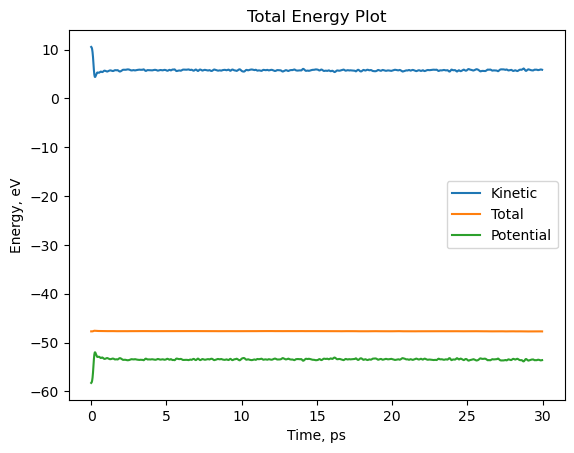

In [452]:
plt.plot(time_len, kinetic_ener*J_to_eV, label='Kinetic')
plt.plot(time_len, total*J_to_eV, label='Total')
plt.plot(time_len, potential_ener*J_to_eV, label='Potential')

plt.xlabel('Time, ps')
plt.ylabel('Energy, eV')
plt.legend()
plt.title('Total Energy Plot')
plt.show()

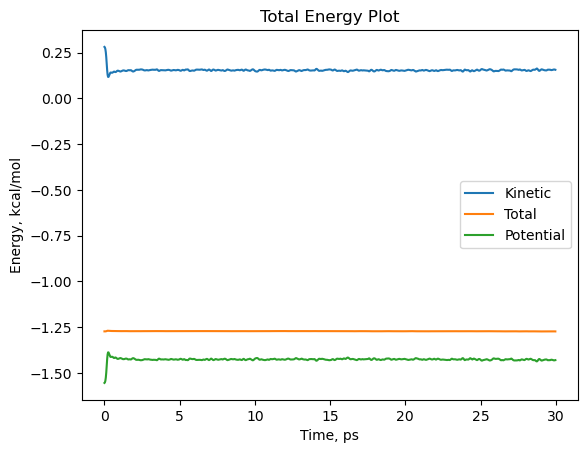

In [453]:
plt.plot(time_len, kinetic_ener*J_to_kpm, label='Kinetic')
plt.plot(time_len, total*J_to_kpm, label='Total')
plt.plot(time_len, potential_ener*J_to_kpm, label='Potential')

plt.xlabel('Time, ps')
plt.ylabel('Energy, kcal/mol')
plt.legend()
plt.title('Total Energy Plot')
plt.show()

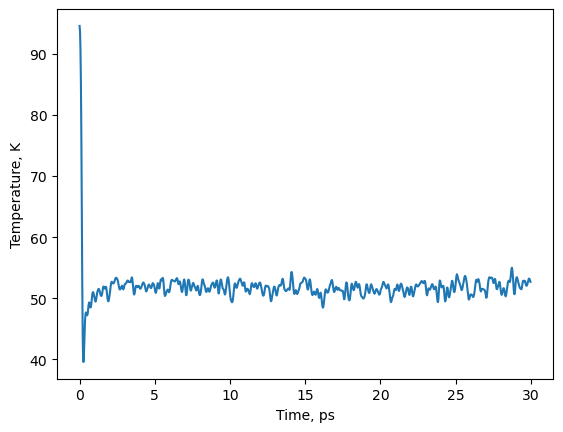

In [454]:
plt.plot(time_len, temps)

plt.xlabel('Time, ps')
plt.ylabel('Temperature, K')
plt.show()

## Argon Simulator Script implemented with CUDA Acceleration
The simulator class object is in the file `ArgonSimCupy.py`

This is about 6 times faster than native numpy.

In [1]:
from ArgonSimCupy import ArgonSim

import cupy as cp
import numpy as np
from cupy import linalg as LA
from matplotlib import pyplot as plt

In [4]:
sim = ArgonSim(
    n_cells = 6, 
    temp = 90, 
    dt = 3e-14, 
    density = 1.374,
    lennard_jones_cutoff = 2.5,
)

In [5]:
%%time
coords = []
velocities = []
sum_potentials = []
mean_potentials = []
accelerations = []
n_steps = 1000

for i in range(n_steps):
    coords.append(sim.coords)
    # potentials.append(sim.potentials)
    sum_potentials.append(sim.pair_potentials.sum())
    mean_potentials.append(sim.pair_potentials.mean())
    accelerations.append(sim.accl)
    velocities.append(sim.velo)
    sim.step()
    # sim.step_velocity_verlet()

CPU times: user 2.99 s, sys: 13 µs, total: 2.99 s
Wall time: 2.99 s


In [6]:
coords = cp.array(coords)
velocities = cp.array(velocities)
mean_potential_ener = cp.array(mean_potentials)
potential_ener = cp.array(sum_potentials)
accelerations = cp.array(accelerations)

In [7]:
J_to_eV = 6.241509e+18
J_to_kpm = sim.n/(4184*sim.coords.shape[0])
time_len = cp.linspace(0, (n_steps-1)*3e-2, n_steps) # pico-second

In [8]:
kinetic_ener = (velocities**2*sim.m_argon_kg/2).sum((1,2))

In [9]:
temps = 2*kinetic_ener/(3*sim.kb*sim.coords.shape[0])
temps.mean()

array(46.95778842)

In [10]:
init_kin = (velocities[0]**2*sim.m_argon_kg/2).sum(1).mean()
init_temp = 2*init_kin/(3*sim.kb)
init_temp

array(85.98418822)

In [11]:
total = kinetic_ener+potential_ener

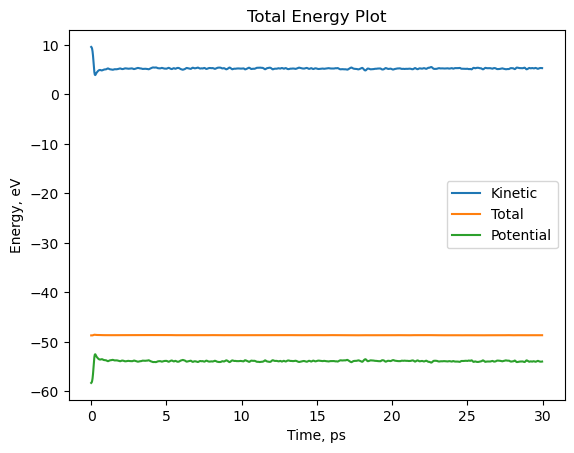

In [12]:
plt.plot(time_len.get(), kinetic_ener.get()*J_to_eV, label='Kinetic')
plt.plot(time_len.get(), total.get()*J_to_eV, label='Total')
plt.plot(time_len.get(), potential_ener.get()*J_to_eV, label='Potential')

plt.xlabel('Time, ps')
plt.ylabel('Energy, eV')
plt.legend()
plt.title('Total Energy Plot')
plt.show()

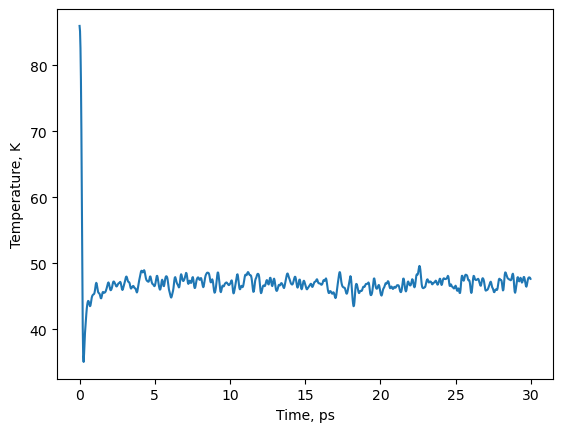

In [13]:
plt.plot(time_len.get(), temps.get())

plt.xlabel('Time, ps')
plt.ylabel('Temperature, K')
plt.show()